In [1]:
import pandas as pd
import numpy as np

from datetime import timedelta

import zucaml.zucaml as ml

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

#### silver

In [2]:
df_silver = pd.read_csv('data/silver/silver.csv')

for feat in ['latitude', 'longitude', 'depth', 'mag']:
    df_silver[feat] = pd.to_numeric(df_silver[feat], downcast = 'float')
    
df_silver['date'] = pd.to_datetime(df_silver['date'], format = '%Y-%m-%d', exact = True)

df_silver = df_silver.dropna()

ml.print_memory(df_silver)
df_silver[:5]

Memory usage: 36.49 MB
797,041 x 7


,latitude,longitude,depth,mag,id,hour,date
0,-4.610,153.175995,35.0,6.5,iscgemsup907200,7,1930-01-18
1,51.389,179.824005,25.0,6.4,iscgem907212,14,1930-02-02
2,-21.871,-175.098999,35.0,6.4,iscgem907224,20,1930-02-14
3,-33.292,-178.005005,15.0,6.3,iscgem907259,15,1930-03-06
4,-7.738,125.807999,10.0,7.0,iscgem907286,7,1930-03-26


#### Set variables

In [3]:
# DataFrames
main_id = 'zone_frame'
time_ref = 'date'
time_frequency = '7D'
target_raw = 'event'
early_warning_number = 1
range_warning_number = 2
pad_df = False

# Problem
event_reference = 5.0
degrees_latitude_grid = 10
km_depth_grid = 100

# Filter
min_latitude = -47
max_latitude = 7
min_longitude = -85
max_longitude = -60
time_cut = pd.datetime(1973, 1, 1)

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


#### events

In [4]:
df_silver['event'] = ((df_silver['mag'] >= event_reference) * 1).astype(np.uint8)

#### filter regions

In [5]:
df_silver['keep'] = (df_silver['latitude'] >= min_latitude) & (df_silver['latitude'] <= max_latitude) & (df_silver['longitude'] >= min_longitude) & (df_silver['longitude'] <= max_longitude)

before_records = len(df_silver)
before_events = df_silver['event'].sum()

df_filtered = df_silver.loc[df_silver['keep']].copy().reset_index()

after_records = len(df_filtered)
after_events = df_filtered['event'].sum()

df_filtered = df_filtered.drop([
    'keep',
    'index',
], axis = 1)

print(f'Records:\t\t{after_records / before_records - 1.0:.0%}\n')
print(f'Events:\t\t\t{after_events / before_events - 1.0:.0%}\n')
print(f'Number of events:\t{after_events:,d}\n')

ml.print_memory(df_filtered)
df_filtered[:5]

Records:		-93%

Events:			-93%

Number of events:	6,108

Memory usage: 2.32 MB
59,217 x 8


,latitude,longitude,depth,mag,id,hour,date,event
0,-15.340000,-75.033997,30.0,6.4,iscgem907464,10,1930-06-25,1
1,-14.946000,-76.050003,15.0,6.6,iscgem907467,21,1930-06-25,1
2,-33.778000,-71.477997,35.0,7.2,iscgem906680,8,1931-03-18,1
3,-32.192001,-71.305000,35.0,6.6,iscgem906476,11,1932-11-29,1
4,-20.500000,-70.156998,35.0,7.2,iscgem905405,8,1933-02-23,1


In [6]:
latlon_dist = df_filtered.copy()

latlon_dist['longitude'] = latlon_dist['longitude'].round()
latlon_dist['latitude'] = latlon_dist['latitude'].round()

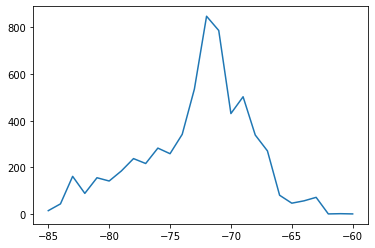

In [7]:
lon_dist = latlon_dist.groupby('longitude').agg({'event': np.sum})['event']
plt.plot(lon_dist.index, lon_dist.values)

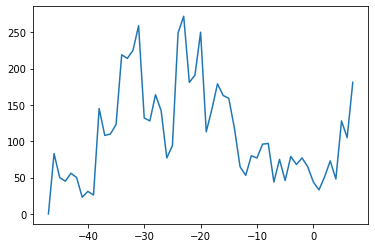

In [8]:
lon_dist = latlon_dist.groupby('latitude').agg({'event': np.sum})['event']
plt.plot(lon_dist.index, lon_dist.values)

#### filter time

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


[Text(0, 0.0, '0'),
 Text(0, 0.5, '0'),
 Text(0, 1.0, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.0, '2'),
 Text(0, 2.5, '2'),
 Text(0, 3.0, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.0, '4'),
 Text(0, 4.5, '4')]

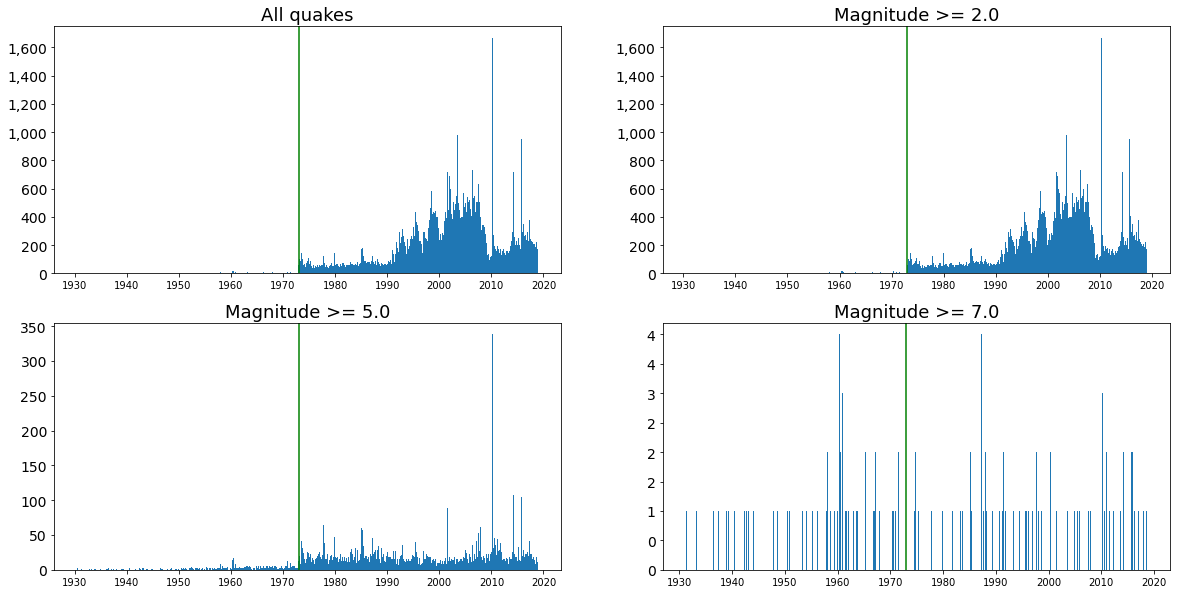

In [9]:
plt.figure(figsize = (20, 10))

title_font_size = 18
axis_font_size = 14

plt.subplot(221).hist(df_filtered['date'], bins = 500)
plt.axvline(time_cut, color = 'green')
plt.title('All quakes', fontsize = title_font_size)
# plt.xlabel('Date', fontsize = 16)
# https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()], fontsize = axis_font_size)
# plt.gca().set_xticklabels([x for x in plt.gca().get_xticks()], fontsize = 14)

plt.subplot(222).hist(df_filtered[df_filtered['mag'] >= 2]['date'], bins = 500)
plt.axvline(time_cut, color = 'green')
plt.title('Magnitude >= ' + str(float(2)), fontsize = title_font_size)
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in y_values], fontsize = axis_font_size)

plt.subplot(223).hist(df_filtered[df_filtered['mag'] >= event_reference]['date'], bins = 500)
plt.axvline(time_cut, color = 'green')
plt.title('Magnitude >= ' + str(event_reference), fontsize = title_font_size)
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in y_values], fontsize = axis_font_size)

plt.subplot(224).hist(df_filtered[df_filtered['mag'] >= 7]['date'], bins = 500)
plt.axvline(time_cut, color = 'green')
plt.title('Magnitude >= ' + str(float(7)), fontsize = title_font_size)
y_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in y_values], fontsize = axis_font_size)

# plt.tight_layout()
# plt.show()

# plt.savefig('histogram.jpg')

In [10]:
df_filtered = df_filtered[df_filtered['date'] > time_cut]

min_date = df_filtered['date'].min()
max_date = df_filtered['date'].max()

print(f'Min date:\t{min_date}\n')
print(f'Max date:\t{max_date}\n')

df_filtered = df_filtered.reset_index().drop([
    'index',
], axis = 1)

ml.print_memory(df_filtered)
df_filtered[:5]

Min date:	1973-01-02 00:00:00

Max date:	2018-12-28 00:00:00

Memory usage: 2.30 MB
58,772 x 8


,latitude,longitude,depth,mag,id,hour,date,event
0,5.404,-82.541000,30.0,5.2,usp000000c,3,1973-01-02,1
1,-27.716,-63.261002,563.0,5.6,usp000000m,2,1973-01-03,1
2,0.683,-80.017998,36.0,4.7,usp0000014,0,1973-01-05,0
3,0.705,-79.961998,40.0,3.8,usp000001q,6,1973-01-06,0
4,-22.354,-69.309998,83.0,4.9,usp000001p,6,1973-01-06,0


#### energy

In [11]:
df_energy = df_filtered.copy()

## check later
df_energy['energy'] = 5.24
df_energy['energy'] += 1.44 * df_energy['mag']
df_energy['energy'] = np.power(10, df_energy['energy'])

reference_energy = df_energy[df_energy['event'] == 1]['energy'].min()

ml.print_memory(df_energy)
df_energy[:5]

Memory usage: 2.75 MB
58,772 x 9


,latitude,longitude,depth,mag,id,hour,date,event,energy
0,5.404,-82.541000,30.0,5.2,usp000000c,3,1973-01-02,1,5.345643e+12
1,-27.716,-63.261002,563.0,5.6,usp000000m,2,1973-01-03,1,2.013725e+13
2,0.683,-80.017998,36.0,4.7,usp0000014,0,1973-01-05,0,1.018592e+12
3,0.705,-79.961998,40.0,3.8,usp000001q,6,1973-01-06,0,5.152288e+10
4,-22.354,-69.309998,83.0,4.9,usp000001p,6,1973-01-06,0,1.976971e+12


#### grid

In [12]:
df_grid = df_energy.copy()

x_degre_km = 94.2
y_degre_km = 111.2

dy = degrees_latitude_grid
dx = int(round(dy * y_degre_km / x_degre_km))
dz = km_depth_grid

grid_values = [
    ('y', 'latitude', dy),
    ('x', 'longitude', dx),
    ('z', 'depth', dz)
]

for new_feature, old_feature, increment in grid_values:
    
    old_feature_min = int(round(df_grid[old_feature].min()))
    
    df_grid[new_feature] = df_grid[old_feature] - old_feature_min
    df_grid[new_feature] = df_grid[new_feature] / increment
    df_grid[new_feature] = df_grid[new_feature].round().astype(int)
    df_grid[new_feature] = df_grid[new_feature] * increment
    df_grid[new_feature] = df_grid[new_feature] + old_feature_min

assert(sum(df_grid['z'] < 0) == 0)

df_grid['zone_frame'] = df_grid['x'].astype(str) + '|' + df_grid['y'].astype(str) + '|' + df_grid['z'].astype(str)

min_x = df_grid['x'].min()
max_x = df_grid['x'].max()
min_y = df_grid['y'].min()
max_y = df_grid['y'].max()
min_z = df_grid['z'].min()
max_z = df_grid['z'].max()

range_x = range(min_x, max_x + dx, dx)
range_y = range(min_y, max_y + dy, dy)
range_z = range(min_z, max_z + dz, dz)

all_zone_frames = [str(x) + '|' + str(y) + '|' + str(z) for x in range_x for y in range_y for z in range_z]

used_x = df_grid['x'].nunique()
used_y = df_grid['y'].nunique()
used_z = df_grid['z'].nunique()
used_time = df_grid['date'].nunique()

print(f'Unique x:\t\t{used_x:,d}\n')
print(f'Unique y:\t\t{used_y:,d}\n')
print(f'Unique z:\t\t{used_z:,d}\n')
print(f'Unique time:\t\t{used_time:,d}\n')
print(f'All zones:\t\t{len(all_zone_frames):,d}\n')

df_grid = df_grid.drop([
    'longitude',
    'latitude',
    'depth',
    'hour',
], axis = 1)

ml.print_memory(df_grid)
df_grid[:5]

Unique x:		3

Unique y:		6

Unique z:		8

Unique time:		13,789

All zones:		144

Memory usage: 3.42 MB
58,772 x 9


,mag,id,date,event,energy,y,x,z,zone_frame
0,5.2,usp000000c,1973-01-02,1,5.345643e+12,3,-85,0,-85|3|0
1,5.6,usp000000m,1973-01-03,1,2.013725e+13,-27,-61,600,-61|-27|600
2,4.7,usp0000014,1973-01-05,0,1.018592e+12,3,-85,0,-85|3|0
3,3.8,usp000001q,1973-01-06,0,5.152288e+10,3,-85,0,-85|3|0
4,4.9,usp000001p,1973-01-06,0,1.976971e+12,-27,-73,100,-73|-27|100


In [13]:
events_per_zone_frame = df_grid.groupby('zone_frame')['event'].sum().reset_index()

events_per_zone_frame['event_perc'] = events_per_zone_frame['event'] / events_per_zone_frame['event'].sum()

events_per_zone_frame.sort_values('event_perc', ascending = False)

,zone_frame,event,event_perc
29,-73|-37|0,862.0,0.152189
24,-73|-27|0,778.0,0.137359
20,-73|-17|100,655.0,0.115643
19,-73|-17|0,603.0,0.106462
25,-73|-27|100,520.0,0.091808
56,-85|3|0,317.0,0.055968
37,-73|-7|100,189.0,0.033369
44,-73|3|0,185.0,0.032662
9,-61|-27|200,182.0,0.032133
36,-73|-7|0,177.0,0.031250


#### all sectors, all timeframes

In [14]:
###################################################
# used for convolutional networks
# adding min to all timeframes have same number of zones 
# in theroy the time filter should be done after reindexing
###################################################

if pad_df:

    zero_fill = ['mag', 'event', 'energy']
    other_fill = {'id': 'non_existant'}

    df_grid = ml.pad(df_grid, 'zone_frame', 'date', all_zone_frames, 'min', zero_fill, other_fill)
    df_grid = ml.pad(df_grid, 'zone_frame', 'date', all_zone_frames, 'max', zero_fill, other_fill)

    df_grid['x'] = df_grid['zone_frame'].str.split('|').str[0].astype(int)
    df_grid['y'] = df_grid['zone_frame'].str.split('|').str[1].astype(int)
    df_grid['z'] = df_grid['zone_frame'].str.split('|').str[2].astype(int)

    assert(df_grid.isna().sum().sum() == 0)

    ml.print_memory(df_grid)
    df_grid[:5]

In [15]:
%%time

# reindex
df_full = ml.reindex_by_minmax(
    df = df_grid.drop(['mag', 'x', 'y', 'z'], axis = 1),
    item = main_id,
    time_ref = time_ref,
    time_freq = time_frequency,
    forwardfill_features = [],
    backfill_features = [],
    zerofill_features = ['energy', 'event'],
)

assert(df_full.isna().sum().sum() == 0)

df_full['event'] = ((df_full['event'] > 0) * 1).astype(np.uint8)

df_full['x'] = df_full['zone_frame'].str.split('|').str[0].astype(int)
df_full['y'] = df_full['zone_frame'].str.split('|').str[1].astype(int)
df_full['z'] = df_full['zone_frame'].str.split('|').str[2].astype(int)

ml.print_memory(df_full)
df_full[:5]

Memory usage: 4.97 MB
106,377 x 7
CPU times: user 802 ms, sys: 159 ms, total: 961 ms
Wall time: 1.08 s


,zone_frame,date,event,energy,x,y,z
0,-73|-37|0,1973-01-17,0,1.976971e+12,-73,-37,0
1,-73|-37|0,1973-01-24,0,0.000000e+00,-73,-37,0
2,-73|-37|0,1973-01-31,0,0.000000e+00,-73,-37,0
3,-73|-37|0,1973-02-07,0,2.703961e+11,-73,-37,0
4,-73|-37|0,1973-02-14,0,7.311392e+11,-73,-37,0


#### Neighbours

In [16]:
df_full_with_neighbours = df_full.copy()

In [17]:
%%time

#### aux func
def get_xyz(zone_frame):
    
    x, y, z = zone_frame.split('|')
    
    x = int(x)
    y = int(y)
    z = int(z)
    
    return x, y, z

#### get neighbours
def get_neighbours(zone_frame, neighbours, used_zone_frames):
    
    this_neighbours = []
    
    this_x, this_y, this_z = get_xyz(zone_frame)
    
    for zf in used_zone_frames:
        x, y, z = get_xyz(zf)
        
        if zone_frame != zf and x in neighbours['x'][this_x] and y in neighbours['y'][this_y] and z in neighbours['z'][this_z]:
            this_neighbours.append(zf)
    
    return this_neighbours

#### calculate distance in xy plane
distance = max(x_degre_km * dx, y_degre_km * dy)

#### aux variable
ranges = {'x': range_x, 'y': range_y}

#### neighbours coordinates
neighbours = {}

#### neighbours coordinates - xy
for dim in ['x', 'y']:
    
    neighbours[dim] = {}

    ordered = {}

    for i, d in enumerate(ranges[dim]):
        ordered[i] = d

    for i, d in ordered.items():
        neighbours[dim][d] = [d]
        if i > 0:
            neighbours[dim][d].append(ordered[i - 1])
        if i < len(ordered) - 1:
            neighbours[dim][d].append(ordered[i + 1])

#### neighbours coordinates - z
neighbours['z'] = {}

for z in range_z:
    
    neighbours['z'][z] = [z]
    
    for z2 in range_z:
        if abs(z - z2) <= distance and z != z2:
             neighbours['z'][z].append(z2)

#### neighbours per zone frame
zone_frames_neighbours = {}

used_zone_frames = df_full['zone_frame'].unique()

for zone_frame in used_zone_frames:
    zone_frames_neighbours[zone_frame] = get_neighbours(zone_frame, neighbours, used_zone_frames)

def get_energy_neighbours(df, used_zone_frames, zone_frames_neighbours):
    
    dfs = []
    
    for zone_frame in used_zone_frames:
        
        df_zone = df.loc[df['zone_frame'] == zone_frame].copy()

        df_zone_neighbours = df.loc[df['zone_frame'].isin(zone_frames_neighbours[zone_frame])].copy()

        df_zone_neighbours = df_zone_neighbours.groupby(['date']).agg({'energy': np.sum}).reset_index()

        new_feature = 'neighbours_' + zone_frame

        df_zone_neighbours = df_zone_neighbours.rename({'energy': new_feature}, axis = 1)

        df_zone_neighbours = df_zone_neighbours.loc[df_zone_neighbours[new_feature] != 0].copy()

        df_zone = pd.merge(
            df_zone,
            df_zone_neighbours,
            how = 'left',
            on = ['date'],
            suffixes = ['_repeated_left', 'repeated_right'],
        )
        
        dfs.append(df_zone)
        
    dfs = pd.concat(dfs)
    
    for feat in dfs:
        if 'repeated' in feat:
            print(f'Warning: repeated features')

    assert(len(dfs) == len(df))

    neighbours_features = [feat for feat in dfs if feat.startswith('neighbours_')]

    dfs['energy_neighbours'] = dfs[neighbours_features].T.sum().T

    dfs = dfs.drop(neighbours_features, axis = 1)
    
    assert(dfs.isna().sum().sum() == 0)
    
    return dfs

df_full_with_neighbours = get_energy_neighbours(df_full, used_zone_frames, zone_frames_neighbours)

ml.print_memory(df_full_with_neighbours)
df_full_with_neighbours[:5]

Memory usage: 6.59 MB
106,377 x 8
CPU times: user 1.38 s, sys: 140 ms, total: 1.52 s
Wall time: 1.52 s


,zone_frame,date,event,energy,x,y,z,energy_neighbours
0,-73|-37|0,1973-01-17,0,1.976971e+12,-73,-37,0,0.000000e+00
1,-73|-37|0,1973-01-24,0,0.000000e+00,-73,-37,0,0.000000e+00
2,-73|-37|0,1973-01-31,0,0.000000e+00,-73,-37,0,1.056818e+14
3,-73|-37|0,1973-02-07,0,2.703961e+11,-73,-37,0,5.248081e+11
4,-73|-37|0,1973-02-14,0,7.311392e+11,-73,-37,0,0.000000e+00


#### Set target

In [18]:
df_gold = ml.set_target(
    df = df_full_with_neighbours,
    item = main_id,
    time_ref = time_ref,
    target = target_raw,
    early_warning = early_warning_number,
    range_warning = range_warning_number,
    drop_na_target = True,
)

balance = df_gold['target'].sum() / len(df_gold)
print(f'{balance:.4%}')

ml.print_memory(df_gold)
df_gold[:5]

7.1049%
Memory usage: 6.59 MB
106,265 x 9


,zone_frame,date,event,energy,x,y,z,energy_neighbours,target
0,-61|-17|0,1976-02-22,1,7.447327e+12,-61,-17,0,0.000000e+00,0.0
1,-61|-17|0,1976-02-29,0,0.000000e+00,-61,-17,0,0.000000e+00,0.0
2,-61|-17|0,1976-03-07,0,0.000000e+00,-61,-17,0,0.000000e+00,0.0
3,-61|-17|0,1976-03-14,0,0.000000e+00,-61,-17,0,0.000000e+00,0.0
4,-61|-17|0,1976-03-21,0,0.000000e+00,-61,-17,0,1.419060e+12,0.0


#### Feature engineering

In [19]:
df_gold = ml.create_reset(
    df = df_gold,
    item = main_id,
    time_ref = time_ref,
    order = None
)

##### M.A.

In [20]:
for window_rolling_mean in [30, 90, 180, 330, 360]:
    df_gold = ml.ts_feature(
        df = df_gold,
        feature_base = 'energy',
        func = 'rolling.mean',
        func_val = window_rolling_mean,
        label = None,
    )

for window_rolling_mean in [30, 90, 180, 330, 360]:
    df_gold = ml.ts_feature(
        df = df_gold,
        feature_base = 'energy_neighbours',
        func = 'rolling.mean',
        func_val = window_rolling_mean,
        label = None,
    )

ml.print_memory(df_gold)
df_gold[:5]

Memory usage: 16.32 MB
106,265 x 20


,zone_frame,date,event,energy,x,y,z,energy_neighbours,target,reset,energy|rolling.mean#30,energy|rolling.mean#90,energy|rolling.mean#180,energy|rolling.mean#330,energy|rolling.mean#360,energy_neighbours|rolling.mean#30,energy_neighbours|rolling.mean#90,energy_neighbours|rolling.mean#180,energy_neighbours|rolling.mean#330,energy_neighbours|rolling.mean#360
46127,-73|-17|600,1994-01-10,1,1.499688e+15,-73,-17,600,3.703961e+11,0.0,23,1.499688e+15,1.499688e+15,1.499688e+15,1.499688e+15,1.499688e+15,3.703961e+11,3.703961e+11,3.703961e+11,3.703961e+11,3.703961e+11
46128,-73|-17|600,1994-01-17,0,0.000000e+00,-73,-17,600,1.905461e+10,0.0,23,7.498438e+14,7.498438e+14,7.498438e+14,7.498438e+14,7.498438e+14,1.947254e+11,1.947254e+11,1.947254e+11,1.947254e+11,1.947254e+11
46129,-73|-17|600,1994-01-24,0,0.000000e+00,-73,-17,600,1.109544e+13,0.0,23,4.998959e+14,4.998959e+14,4.998959e+14,4.998959e+14,4.998959e+14,3.828295e+12,3.828295e+12,3.828295e+12,3.828295e+12,3.828295e+12
46130,-73|-17|600,1994-01-31,0,0.000000e+00,-73,-17,600,7.585432e+12,0.0,23,3.749219e+14,3.749219e+14,3.749219e+14,3.749219e+14,3.749219e+14,4.767579e+12,4.767579e+12,4.767579e+12,4.767579e+12,4.767579e+12
46131,-73|-17|600,1994-02-07,0,0.000000e+00,-73,-17,600,1.037530e+13,0.0,23,2.999375e+14,2.999375e+14,2.999375e+14,2.999375e+14,2.999375e+14,5.889123e+12,5.889123e+12,5.889123e+12,5.889123e+12,5.889123e+12


##### Ratios

In [21]:
df_gold = ml.math_feature(
    df = df_gold,
    feature_1 = 'energy|rolling.mean#30',
    feature_2 = 'energy|rolling.mean#360',
    func = 'ratio',
    label = None,
)

df_gold = ml.math_feature(
    df = df_gold,
    feature_1 = 'energy|rolling.mean#90',
    feature_2 = 'energy|rolling.mean#360',
    func = 'ratio',
    label = None,
)

df_gold = ml.math_feature(
    df = df_gold,
    feature_1 = 'energy|rolling.mean#180',
    feature_2 = 'energy|rolling.mean#360',
    func = 'ratio',
    label = None,
)

df_gold = ml.math_feature(
    df = df_gold,
    feature_1 = 'energy|rolling.mean#330',
    feature_2 = 'energy|rolling.mean#360',
    func = 'ratio',
    label = None,
)

ml.print_memory(df_gold)
df_gold[:5]

Memory usage: 19.56 MB
106,265 x 24


,zone_frame,date,event,energy,x,y,z,energy_neighbours,target,reset,energy|rolling.mean#30,energy|rolling.mean#90,energy|rolling.mean#180,energy|rolling.mean#330,energy|rolling.mean#360,energy_neighbours|rolling.mean#30,energy_neighbours|rolling.mean#90,energy_neighbours|rolling.mean#180,energy_neighbours|rolling.mean#330,energy_neighbours|rolling.mean#360,energy|rolling.mean#30||ratio||energy|rolling.mean#360,energy|rolling.mean#90||ratio||energy|rolling.mean#360,energy|rolling.mean#180||ratio||energy|rolling.mean#360,energy|rolling.mean#330||ratio||energy|rolling.mean#360
46127,-73|-17|600,1994-01-10,1,1.499688e+15,-73,-17,600,3.703961e+11,0.0,23,1.499688e+15,1.499688e+15,1.499688e+15,1.499688e+15,1.499688e+15,3.703961e+11,3.703961e+11,3.703961e+11,3.703961e+11,3.703961e+11,1.0,1.0,1.0,1.0
46128,-73|-17|600,1994-01-17,0,0.000000e+00,-73,-17,600,1.905461e+10,0.0,23,7.498438e+14,7.498438e+14,7.498438e+14,7.498438e+14,7.498438e+14,1.947254e+11,1.947254e+11,1.947254e+11,1.947254e+11,1.947254e+11,1.0,1.0,1.0,1.0
46129,-73|-17|600,1994-01-24,0,0.000000e+00,-73,-17,600,1.109544e+13,0.0,23,4.998959e+14,4.998959e+14,4.998959e+14,4.998959e+14,4.998959e+14,3.828295e+12,3.828295e+12,3.828295e+12,3.828295e+12,3.828295e+12,1.0,1.0,1.0,1.0
46130,-73|-17|600,1994-01-31,0,0.000000e+00,-73,-17,600,7.585432e+12,0.0,23,3.749219e+14,3.749219e+14,3.749219e+14,3.749219e+14,3.749219e+14,4.767579e+12,4.767579e+12,4.767579e+12,4.767579e+12,4.767579e+12,1.0,1.0,1.0,1.0
46131,-73|-17|600,1994-02-07,0,0.000000e+00,-73,-17,600,1.037530e+13,0.0,23,2.999375e+14,2.999375e+14,2.999375e+14,2.999375e+14,2.999375e+14,5.889123e+12,5.889123e+12,5.889123e+12,5.889123e+12,5.889123e+12,1.0,1.0,1.0,1.0


##### Track last event

In [22]:
df_gold = ml.track_feature(
    df = df_gold,
    feature_base = time_ref,
    condition = df_gold[target_raw] > 0,
    track_window = 0,
    track_function = 'diff.days',
    label = 'days.since.last'
)

ml.print_memory(df_gold)
df_gold[:5]

Memory usage: 20.37 MB
106,265 x 25


,zone_frame,date,event,energy,x,y,z,energy_neighbours,target,reset,energy|rolling.mean#30,energy|rolling.mean#90,energy|rolling.mean#180,energy|rolling.mean#330,energy|rolling.mean#360,energy_neighbours|rolling.mean#30,energy_neighbours|rolling.mean#90,energy_neighbours|rolling.mean#180,energy_neighbours|rolling.mean#330,energy_neighbours|rolling.mean#360,energy|rolling.mean#30||ratio||energy|rolling.mean#360,energy|rolling.mean#90||ratio||energy|rolling.mean#360,energy|rolling.mean#180||ratio||energy|rolling.mean#360,energy|rolling.mean#330||ratio||energy|rolling.mean#360,days.since.last
46127,-73|-17|600,1994-01-10,1,1.499688e+15,-73,-17,600,3.703961e+11,0.0,23,1.499688e+15,1.499688e+15,1.499688e+15,1.499688e+15,1.499688e+15,3.703961e+11,3.703961e+11,3.703961e+11,3.703961e+11,3.703961e+11,1.0,1.0,1.0,1.0,0.0
46128,-73|-17|600,1994-01-17,0,0.000000e+00,-73,-17,600,1.905461e+10,0.0,23,7.498438e+14,7.498438e+14,7.498438e+14,7.498438e+14,7.498438e+14,1.947254e+11,1.947254e+11,1.947254e+11,1.947254e+11,1.947254e+11,1.0,1.0,1.0,1.0,7.0
46129,-73|-17|600,1994-01-24,0,0.000000e+00,-73,-17,600,1.109544e+13,0.0,23,4.998959e+14,4.998959e+14,4.998959e+14,4.998959e+14,4.998959e+14,3.828295e+12,3.828295e+12,3.828295e+12,3.828295e+12,3.828295e+12,1.0,1.0,1.0,1.0,14.0
46130,-73|-17|600,1994-01-31,0,0.000000e+00,-73,-17,600,7.585432e+12,0.0,23,3.749219e+14,3.749219e+14,3.749219e+14,3.749219e+14,3.749219e+14,4.767579e+12,4.767579e+12,4.767579e+12,4.767579e+12,4.767579e+12,1.0,1.0,1.0,1.0,21.0
46131,-73|-17|600,1994-02-07,0,0.000000e+00,-73,-17,600,1.037530e+13,0.0,23,2.999375e+14,2.999375e+14,2.999375e+14,2.999375e+14,2.999375e+14,5.889123e+12,5.889123e+12,5.889123e+12,5.889123e+12,5.889123e+12,1.0,1.0,1.0,1.0,28.0


##### Clean and order

In [23]:
df_gold = df_gold.drop('reset', axis = 1)

df_gold = df_gold.sort_values(['zone_frame', 'date']).reset_index().drop('index', axis = 1)

In [24]:
check = df_gold[df_gold['target'] == 1].index[0]

df_gold[check - 5:check + 8]

,zone_frame,date,event,energy,x,y,z,energy_neighbours,target,energy|rolling.mean#30,energy|rolling.mean#90,energy|rolling.mean#180,energy|rolling.mean#330,energy|rolling.mean#360,energy_neighbours|rolling.mean#30,energy_neighbours|rolling.mean#90,energy_neighbours|rolling.mean#180,energy_neighbours|rolling.mean#330,energy_neighbours|rolling.mean#360,energy|rolling.mean#30||ratio||energy|rolling.mean#360,energy|rolling.mean#90||ratio||energy|rolling.mean#360,energy|rolling.mean#180||ratio||energy|rolling.mean#360,energy|rolling.mean#330||ratio||energy|rolling.mean#360,days.since.last
148,-61|-17|0,1978-12-24,0,0.000000e+00,-61,-17,0,0.000000e+00,0.0,0.000000e+00,2.196634e+10,6.325032e+10,6.325032e+10,6.325032e+10,5.907209e+11,6.711260e+11,9.458059e+11,9.458059e+11,9.458059e+11,0.000000,0.347292,1.0,1.0,1036.0
149,-61|-17|0,1978-12-31,0,0.000000e+00,-61,-17,0,0.000000e+00,0.0,0.000000e+00,2.196634e+10,6.282865e+10,6.282865e+10,6.282865e+10,5.907209e+11,6.711260e+11,9.395006e+11,9.395006e+11,9.395006e+11,0.000000,0.349623,1.0,1.0,1043.0
150,-61|-17|0,1979-01-07,0,0.000000e+00,-61,-17,0,0.000000e+00,0.0,0.000000e+00,2.196634e+10,6.241257e+10,6.241257e+10,6.241257e+10,5.907209e+11,6.711260e+11,9.332787e+11,9.332787e+11,9.332787e+11,0.000000,0.351954,1.0,1.0,1050.0
151,-61|-17|0,1979-01-14,0,0.000000e+00,-61,-17,0,0.000000e+00,0.0,0.000000e+00,2.196634e+10,6.200196e+10,6.200196e+10,6.200196e+10,5.434189e+11,6.711260e+11,9.271387e+11,9.271387e+11,9.271387e+11,0.000000,0.354285,1.0,1.0,1057.0
152,-61|-17|0,1979-01-21,0,0.000000e+00,-61,-17,0,2.754231e+12,0.0,0.000000e+00,2.196634e+10,6.159672e+10,6.159672e+10,6.159672e+10,6.352266e+11,6.526773e+11,9.390805e+11,9.390805e+11,9.390805e+11,0.000000,0.356615,1.0,1.0,1064.0
153,-61|-17|0,1979-01-28,0,0.000000e+00,-61,-17,0,0.000000e+00,1.0,0.000000e+00,2.196634e+10,6.119674e+10,6.119674e+10,6.119674e+10,6.012735e+11,6.307109e+11,9.329826e+11,9.329826e+11,9.329826e+11,0.000000,0.358946,1.0,1.0,1071.0
154,-61|-17|0,1979-02-04,0,0.000000e+00,-61,-17,0,0.000000e+00,1.0,0.000000e+00,2.196634e+10,6.080192e+10,6.080192e+10,6.080192e+10,5.988809e+11,6.307109e+11,9.269633e+11,9.269633e+11,9.269633e+11,0.000000,0.361277,1.0,1.0,1078.0
155,-61|-17|0,1979-02-11,1,2.754231e+12,-61,-17,0,0.000000e+00,0.0,9.180768e+10,5.256890e+10,7.806749e+10,7.806749e+10,7.806749e+10,5.988809e+11,6.307109e+11,9.210212e+11,9.210212e+11,9.210212e+11,1.176004,0.673378,1.0,1.0,0.0
156,-61|-17|0,1979-02-18,0,0.000000e+00,-61,-17,0,0.000000e+00,0.0,9.180768e+10,5.256890e+10,7.757025e+10,7.757025e+10,7.757025e+10,5.070732e+11,6.307109e+11,9.151549e+11,9.151549e+11,9.151549e+11,1.183543,0.677694,1.0,1.0,7.0
157,-61|-17|0,1979-02-25,0,0.000000e+00,-61,-17,0,1.976971e+12,0.0,9.180768e+10,5.256890e+10,7.707929e+10,7.707929e+10,7.707929e+10,5.729722e+11,6.526773e+11,9.218752e+11,9.218752e+11,9.218752e+11,1.191081,0.682011,1.0,1.0,14.0


#### output

In [25]:
unsigned_feats = ['event', 'target', 'z']
integer_feats = ['x', 'y']
float_feats = []
for feat in df_gold:
    if feat.startswith('energy|rolling'):
        float_feats.append(feat)
    if feat.startswith('energy_neighbours|rolling'):
        float_feats.append(feat)

In [26]:
df_gold = ml.downcast_csv(df_gold, unsigned_feats, integer_feats, float_feats)

Downcast: -45%


In [27]:
balance = df_gold['target'].sum() / len(df_gold)

print(f'{balance:.6%}')

7.104879%


In [28]:
%%time

ml.print_csv(df_gold, 'data/gold/', 'gold')

Memory usage: 10.34 MB
106,265 x 24
CPU times: user 2.27 s, sys: 49.8 ms, total: 2.32 s
Wall time: 2.32 s
